In [1]:
import keras
from keras.datasets import cifar10
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Summary

Most of us will acknowledge that it is a challenge to find back a specific picture that we took months ago. Efficient image retrieval is a challenging task in many domains. <br>

In this notebook we build a simple Content Based Image Retrieval (CBIR) by generating image features using: <br>
- <b>Histograms</b>
- <b>Mean</b> & <b>Moment</b> of the RGB Color Space
- <b>Deep Learning</b> (VGG16 & VGG19)

<br>
We will be using the CIFAR-10 dataset for this notebook. <br>
This dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. <br>
There are 50,000 training images and 10,000 test images. <br>

The CIFAR-10 dataset can be easily loaded from Keras. <br>
<br>
<br>
We train (generate image features) the CBIR model using the images in the training set. <br>
We then get 10 random images from the test set (query images). <br>
For each of the images from the test set, we compute how similar they are according to the images in the training set using Eucledian distance between the image features. <br>
We retrieve the images from the training set that are similar to the query image and measure the performance of the CBIR model using Precision and Recall measure.

In [3]:
(X_train,y_train),(X_test,y_test) = cifar10.load_data() 

In [4]:
X_train.shape

(50000, 32, 32, 3)

### Display first 500 images (25 rows x 20 columns)

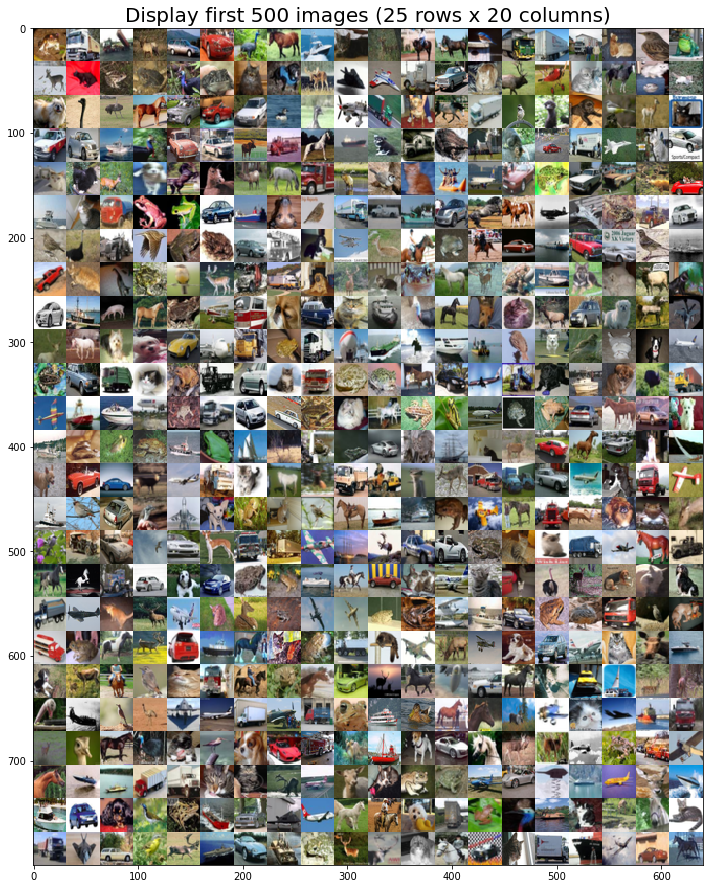

In [5]:
vStack = []
for j in range(25):
    h_list = [X_train[i+j*20] for i in range(20)]
    h_tuple = tuple(h_list)
    vStack.append(np.hstack((h_tuple)))

image_list = [tuple(vStack[j]) for j in range(25)]
image = np.vstack((tuple(image_list)))

plt.figure(figsize=(12,25))
plt.title('Display first 500 images (25 rows x 20 columns)', fontsize=20)
plt.imshow(image)

In [6]:
pd.Series(map(lambda x: x[0], y_train)).value_counts()
#There are 10 classes, each of them have 5000 images

9    5000
8    5000
7    5000
6    5000
5    5000
4    5000
3    5000
2    5000
1    5000
0    5000
dtype: int64

In [7]:
#Get the index of all images in a 10 x 5000 matrix (index_class)
index_class = []
for k in range(10):
    index_class.append([])
    for i,j in enumerate(list(y_train)):
        if j == k:
            index_class[k].append(i)

### Display 10 images of each class per row

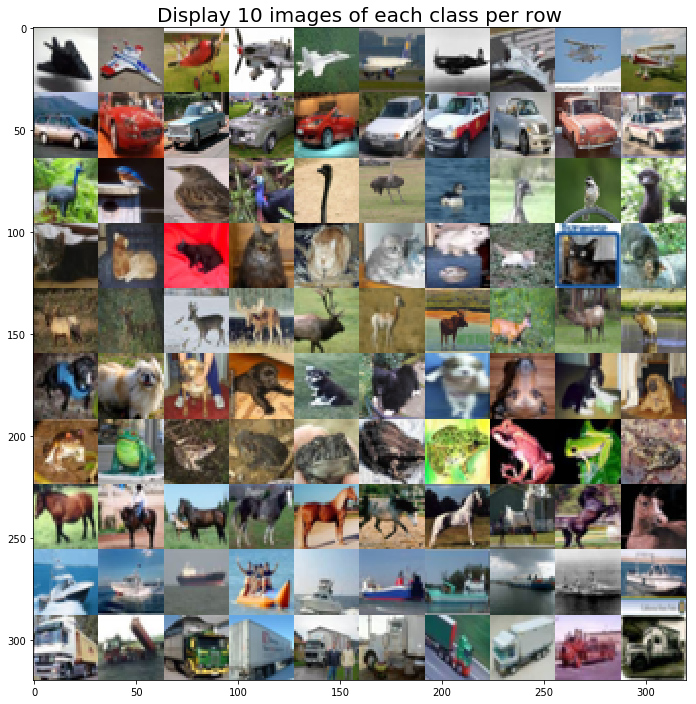

In [8]:
vStack = []
for j in range(10):
    h_list = [X_train[index_class[j][i]] for i in range(10)]
    h_tuple = tuple(h_list)
    vStack.append(np.hstack((h_tuple)))

image_list = [tuple(vStack[j]) for j in range(10)]
image = np.vstack((tuple(image_list)))

plt.figure(figsize=(12,12))
plt.title('Display 10 images of each class per row', fontsize=20)
plt.imshow(image)

In [9]:
num_test_images = 10
random_indices = [random.randint(1, 10000) for i in range(num_test_images)] 
#Get 10 random indices to get images from test set

# 1. Content Based Image Retrieval using Histograms

In [10]:
#Ellipse mask
w = 32
h = 32
cX = 16
cY = 16
(axesX, axesY) = (int(w * 0.7) // 2, int(h * 0.7) // 2)
ellipMask = np.zeros(X_train[0].shape[:2], dtype = "uint8")
cv2.ellipse(ellipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
X_train_hist = []  #This contains the histogram flattened list of 5000 training images
for i in range(X_train.shape[0]):
    #hsv_image = cv2.cvtColor(X_train[i], cv2.COLOR_RGB2HSV)
    hist = []
    color = ('b','g','r')
    for c,col in enumerate(color):
        hsv_image = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2HSV)
        histr = cv2.calcHist([X_train[i]],[c],ellipMask,[64],[0,256])
        hist.append(histr)
    hist = np.array(hist).flatten()
    hist_flatten = cv2.normalize(hist, hist)
    X_train_hist.append(hist_flatten)
    
images_list = [X_train[i] for i in range(X_train.shape[0])]

X_train_hist_df = pd.DataFrame()
X_train_hist_df['IMAGES'] = images_list
X_train_hist_df['HIST_TRAIN'] = X_train_hist
X_train_hist_df['SIMILARITY'] = 0.0
print(X_train_hist_df.shape)
X_train_hist_df.head()

(50000, 3)


,IMAGES,HIST_TRAIN,SIMILARITY
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...","[0.0, 0.0, 0.040154897, 0.020077448, 0.0100387...",0.0
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.007983666, 0.03193...",0.0
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...","[0.0, 0.0, 0.0, 0.0, 0.007296549, 0.0, 0.00729...",0.0
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...","[0.0, 0.053285465, 0.097690016, 0.01776182, 0....",0.0


In [12]:
font = cv2.FONT_HERSHEY_SIMPLEX
#32x32 white image
blank = np.zeros([32,32],dtype=np.uint8)
blank.fill(255) 
blank = cv2.cvtColor(blank, cv2.COLOR_BGR2RGB)

def find_sim(X_train_hist_df,hist_test_flatten):
    for index,row in X_train_hist_df.iterrows():
        sim = np.linalg.norm(hist_test_flatten - row['HIST_TRAIN'])
        X_train_hist_df.at[index,'SIMILARITY']=sim
    return X_train_hist_df

def write_on_blank(blank,text):
    image = cv2.putText(blank,str(text),(9,15), font, 0.6,(0,0,0),2,cv2.LINE_AA)
    return image

Mean Precision = 0.1435
Mean Recall = 0.1201


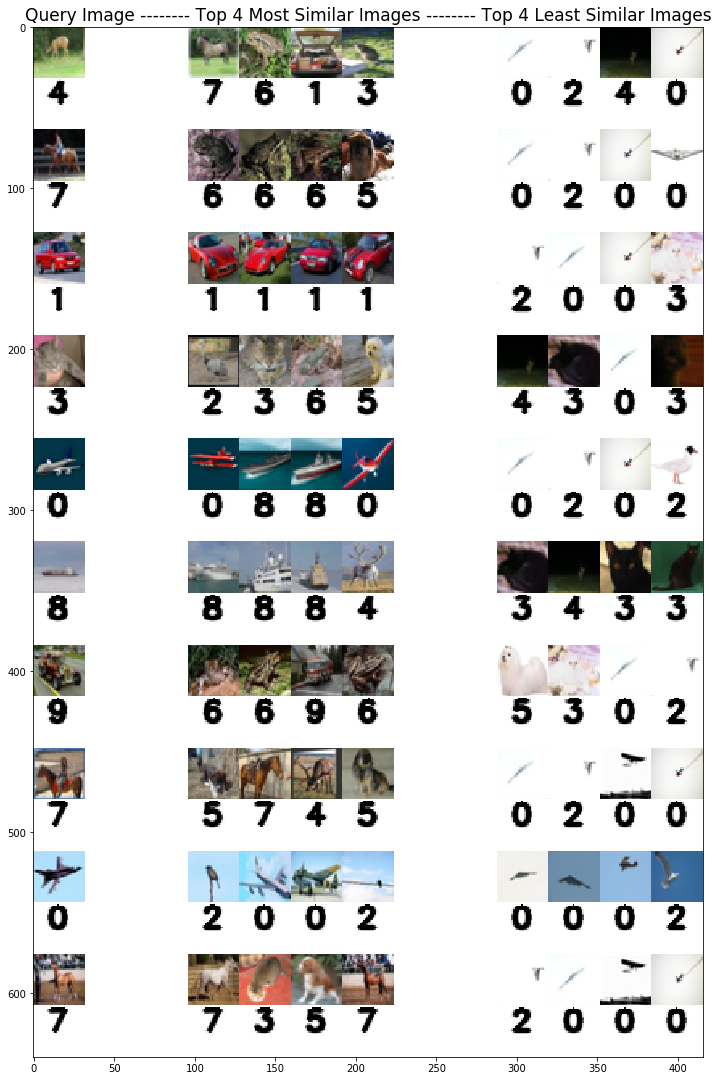

In [13]:
final_stack_image = []
precision_list = []
recall_list = []
for index in random_indices:
    test_image = X_test[index]
    hist_test = []
    color = ('b','g','r')
    for c,col in enumerate(color):
        hsv_test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2HSV)
        histr = cv2.calcHist([test_image],[c],ellipMask,[64],[0,256])
        hist_test.append(histr)
    hist_test = np.array(hist_test).flatten()
    hist_test_flatten = cv2.normalize(hist_test,hist_test)  #Histogram of the test image

    #compute similarity
    X_train_hist_df_with_sim = find_sim(X_train_hist_df,hist_test_flatten)
    
    #Set the similarity threshold to the top 10 percent (If the images are this similar, retrieve the images)
    sim_threshold = X_train_hist_df_with_sim['SIMILARITY'].max() - (X_train_hist_df_with_sim['SIMILARITY'].max())/10
    n_retrieved_images = X_train_hist_df_with_sim[X_train_hist_df_with_sim['SIMILARITY']>=sim_threshold].shape[0]
    n_relevant_images = 5000 #We know this because each class has 5000 images in the training set

    #Top N most similar images
    top_n_most_sim_indices = list(X_train_hist_df_with_sim.sort_values(['SIMILARITY'],ascending=[True])[:n_retrieved_images].index.values)
    top_n_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices]))
    top_4_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices[:4]]))
    top_n_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices]
    top_4_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices[:4]]
    top_4_most_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_most_sim_classes[i]) for i in range(4)]))

    #Top N least similar images
    top_n_least_sim_indices = list(X_train_hist_df_with_sim.sort_values(['SIMILARITY'],ascending=[False])[:25].index.values)
    top_n_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices]))
    top_4_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices[:4]]))
    top_n_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices]
    top_4_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices[:4]]
    top_4_least_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_least_sim_classes[i]) for i in range(4)]))
    
    #Calculate precision & recall at the given similarity threshold
    n_similar_images_retrieved = (top_n_most_sim_classes==y_test[index][0]).astype(float).sum()
    precision = (n_similar_images_retrieved/n_retrieved_images).round(4)
    precision_list.append(precision)
    recall = (n_similar_images_retrieved/n_relevant_images).round(4)
    recall_list.append(recall)

    image_stack = np.hstack((test_image,blank,blank,top_4_most_sim_images,blank,blank,top_4_least_sim_images))
    blank_stack = np.hstack((write_on_blank(blank.copy(),y_test[index][0]),blank,blank,top_4_most_sim_blank_classes,
                             blank,blank,top_4_least_sim_blank_classes))
    final_stack_image.append(np.vstack((image_stack,blank_stack)))
    
final_output = np.vstack(tuple([final_stack_image[i] for i in range(num_test_images)]))
print('Mean Precision = ' + str(np.mean(precision_list).round(4)))
print('Mean Recall = ' + str(np.mean(recall_list).round(4)))
plt.figure(figsize=(12,120))
plt.title('Query Image -------- Top 4 Most Similar Images -------- Top 4 Least Similar Images', fontsize = 17)
plt.imshow(final_output)

# 2. Content Based Image Retrieval using Mean & Moment of Color Channels

In [14]:
#Create two columns in the X_train_mm_df dataframe, one for Mean and another for Moment of Color Channels
def get_mean(img):
    mean_red = img[:,:,0].mean()
    mean_blue = img[:,:,1].mean()
    mean_green = img[:,:,2].mean()
    #mn_value = (mean_red, mean_blue, mean_green)
    #x = cv2.normalize(mn_value, mn_value)
    #return (x[0][0],x[1][0],x[2][0])
    return (mean_red, mean_blue, mean_green)

def get_moment(img):
    red = cv2.moments(img[:,:,0])
    blue = cv2.moments(img[:,:,1])
    green = cv2.moments(img[:,:,2])
    moment_red = ((red['m10']/red['m00'],red['m01']/red['m00'])) #(cX,cY)
    moment_blue = ((blue['m10']/blue['m00'],blue['m01']/blue['m00']))
    moment_green = ((green['m10']/green['m00'],green['m01']/green['m00']))
    #mt_value = (moment_red, moment_blue, moment_green)
    #x = cv2.normalize(mt_value, mt_value)
    #return (x[0][0],x[1][0],x[2][0])
    return (moment_red, moment_blue, moment_green)

images_list = [X_train[i] for i in range(X_train.shape[0])]
color_mean = [get_mean(X_train[i]) for i in range(X_train.shape[0])]
color_moment = [get_moment(X_train[i]) for i in range(X_train.shape[0])]

X_train_mm_df = pd.DataFrame()
X_train_mm_df['IMAGES'] = images_list
X_train_mm_df['MEAN'] = color_mean
X_train_mm_df['MOMENT'] = color_moment
X_train_mm_df['SIMILARITY_MEAN'] = 0.0
X_train_mm_df['SIMILARITY_MOMENT'] = 0.0
print(X_train_mm_df.shape)
X_train_mm_df.head()

(50000, 5)


,IMAGES,MEAN,MOMENT,SIMILARITY_MEAN,SIMILARITY_MOMENT
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...","(141.205078125, 105.099609375, 64.037109375)","((15.40869607314273, 16.358693998367844), (15....",0.0,0.0
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...","(130.19921875, 130.365234375, 130.4775390625)","((15.213697458822118, 14.619655875911313), (14...",0.0,0.0
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...","(133.484375, 135.15234375, 132.5849609375)","((14.608290413203793, 10.831792110499824), (14...",0.0,0.0
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...","(99.9794921875, 83.279296875, 57.4140625)","((15.710135867707244, 16.234237490110278), (15...",0.0,0.0
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...","(92.021484375, 102.400390625, 116.0029296875)","((14.6943011779688, 14.140019102196753), (14.8...",0.0,0.0


In [15]:
def find_sim_mean(X_train_mm_df,mm_test_flatten):
    for index,row in X_train_mm_df.iterrows():
        sim = np.linalg.norm(np.array(mm_test_flatten) - np.array(row['MEAN']))
        X_train_mm_df.at[index,'SIMILARITY_MEAN']=sim
    return X_train_mm_df

def find_sim_moment(X_train_mm_df,mm_test_flatten):
    for index,row in X_train_mm_df.iterrows():
        sim = np.linalg.norm(np.array(mm_test_flatten).flatten() - np.array(row['MOMENT']).flatten())
        X_train_mm_df.at[index,'SIMILARITY_MOMENT']=sim
    return X_train_mm_df

### Mean of Color Channels

Mean Precision = 0.1872
Mean Recall = 0.1645


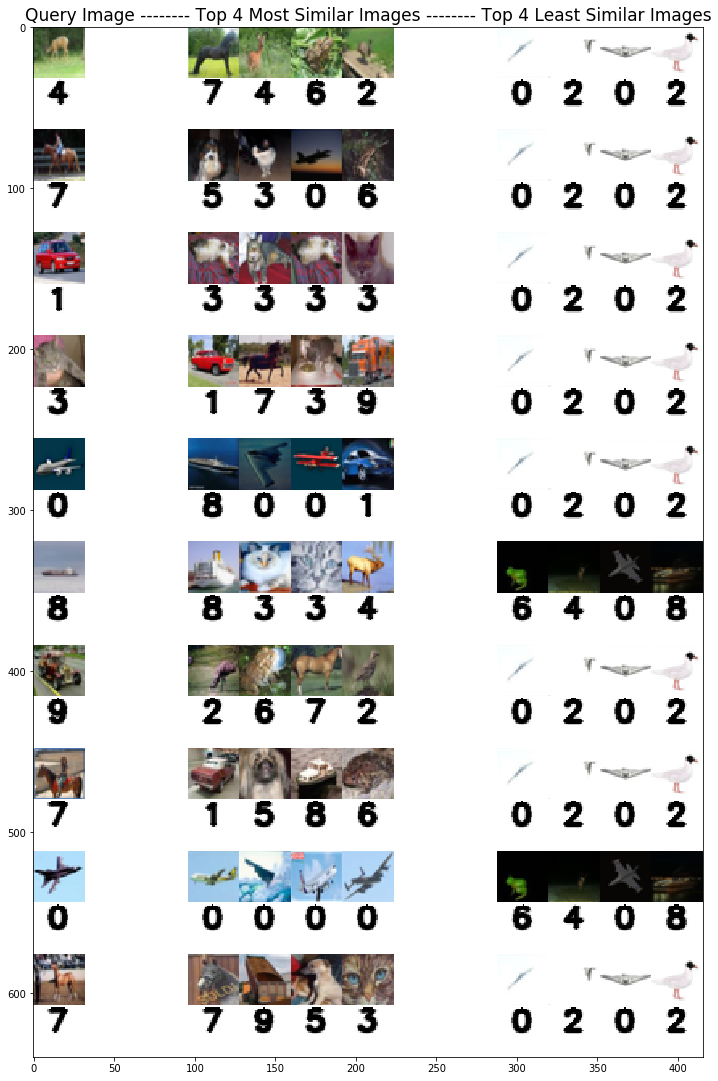

In [16]:
final_stack_image = []
precision_list = []
recall_list = []
for index in random_indices:
    test_image = X_test[index]
    mm_test_flatten = get_mean(test_image)

    #compute similarity
    X_train_mm_df_with_sim = find_sim_mean(X_train_mm_df,mm_test_flatten)
    
    #Set the similarity threshold to the top 10 percent (If the images are this similar, retrieve the images)
    sim_threshold = X_train_mm_df_with_sim['SIMILARITY_MEAN'].min() + (X_train_mm_df_with_sim['SIMILARITY_MEAN'].max())/10
    n_retrieved_images = X_train_mm_df_with_sim[X_train_mm_df_with_sim['SIMILARITY_MEAN']<=sim_threshold].shape[0]
    n_relevant_images = 5000 #We know this because each class has 5000 images in the training set

    #Top N most similar images
    top_n_most_sim_indices = list(X_train_mm_df_with_sim.sort_values(['SIMILARITY_MEAN'],ascending=[True])[:n_retrieved_images].index.values)
    top_n_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices]))
    top_4_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices[:4]]))
    top_n_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices]
    top_4_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices[:4]]
    top_4_most_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_most_sim_classes[i]) for i in range(4)]))

    #Top N least similar images
    top_n_least_sim_indices = list(X_train_mm_df_with_sim.sort_values(['SIMILARITY_MEAN'],ascending=[False])[:25].index.values)
    top_n_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices]))
    top_4_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices[:4]]))
    top_n_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices]
    top_4_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices[:4]]
    top_4_least_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_least_sim_classes[i]) for i in range(4)]))
    
    #Calculate precision & recall at the given similarity threshold
    n_similar_images_retrieved = (top_n_most_sim_classes==y_test[index][0]).astype(float).sum()
    precision = (n_similar_images_retrieved/n_retrieved_images).round(4)
    precision_list.append(precision)
    recall = (n_similar_images_retrieved/n_relevant_images).round(4)
    recall_list.append(recall)

    image_stack = np.hstack((test_image,blank,blank,top_4_most_sim_images,blank,blank,top_4_least_sim_images))
    blank_stack = np.hstack((write_on_blank(blank.copy(),y_test[index][0]),blank,blank,top_4_most_sim_blank_classes,
                             blank,blank,top_4_least_sim_blank_classes))
    final_stack_image.append(np.vstack((image_stack,blank_stack)))
    
final_output = np.vstack(tuple([final_stack_image[i] for i in range(num_test_images)]))
print('Mean Precision = ' + str(np.mean(precision_list).round(4)))
print('Mean Recall = ' + str(np.mean(recall_list).round(4)))
plt.figure(figsize=(12,120))
plt.title('Query Image -------- Top 4 Most Similar Images -------- Top 4 Least Similar Images', fontsize = 17)
plt.imshow(final_output)

### Moment of Color Channels

Mean Precision = 0.1115
Mean Recall = 0.1546


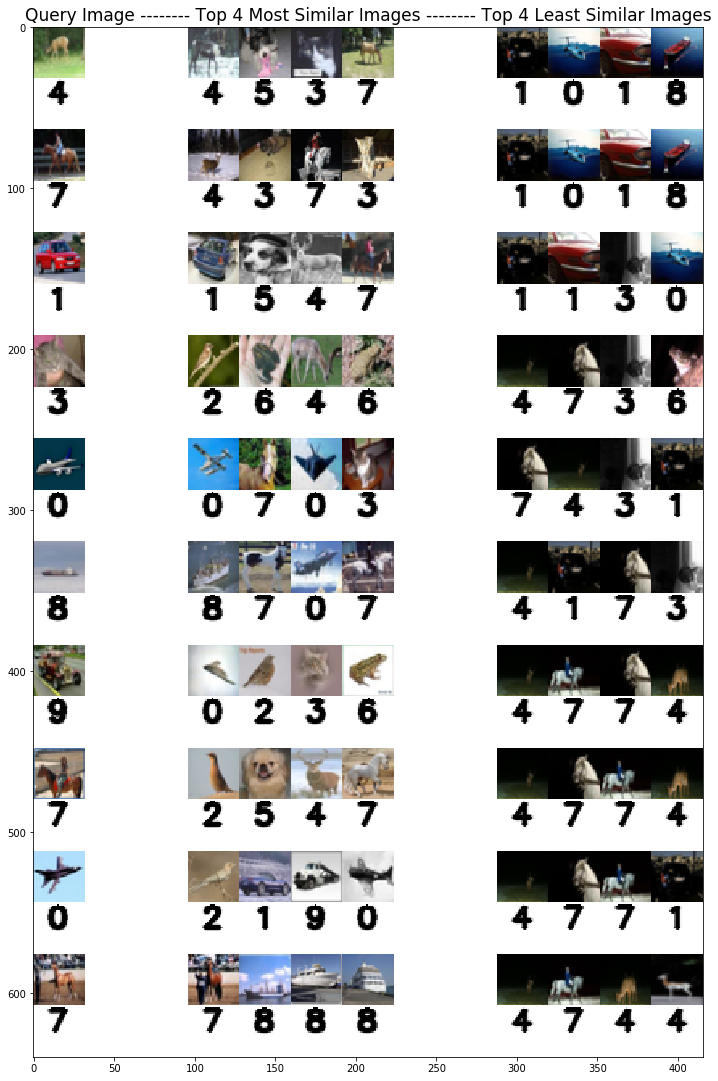

In [17]:
final_stack_image = []
precision_list = []
recall_list = []
for index in random_indices:
    test_image = X_test[index]
    mm_test_flatten = get_moment(test_image)

    #compute similarity
    X_train_mm_df_with_sim = find_sim_moment(X_train_mm_df,mm_test_flatten)
    
    #Set the similarity threshold to the top 10 percent (If the images are this similar, retrieve the images)
    sim_threshold = X_train_mm_df_with_sim['SIMILARITY_MOMENT'].min() + (X_train_mm_df_with_sim['SIMILARITY_MOMENT'].max())/10
    n_retrieved_images = X_train_mm_df_with_sim[X_train_mm_df_with_sim['SIMILARITY_MOMENT']<=sim_threshold].shape[0]
    n_relevant_images = 5000 #We know this because each class has 5000 images in the training set

    #Top N most similar images
    top_n_most_sim_indices = list(X_train_mm_df_with_sim.sort_values(['SIMILARITY_MOMENT'],ascending=[True])[:n_retrieved_images].index.values)
    top_n_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices]))
    top_4_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices[:4]]))
    top_n_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices]
    top_4_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices[:4]]
    top_4_most_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_most_sim_classes[i]) for i in range(4)]))

    #Top N least similar images
    top_n_least_sim_indices = list(X_train_mm_df_with_sim.sort_values(['SIMILARITY_MOMENT'],ascending=[False])[:25].index.values)
    top_n_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices]))
    top_4_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices[:4]]))
    top_n_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices]
    top_4_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices[:4]]
    top_4_least_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_least_sim_classes[i]) for i in range(4)]))
    
    #Calculate precision & recall at the given similarity threshold
    n_similar_images_retrieved = (top_n_most_sim_classes==y_test[index][0]).astype(float).sum()
    precision = (n_similar_images_retrieved/n_retrieved_images).round(4)
    precision_list.append(precision)
    recall = (n_similar_images_retrieved/n_relevant_images).round(4)
    recall_list.append(recall)

    image_stack = np.hstack((test_image,blank,blank,top_4_most_sim_images,blank,blank,top_4_least_sim_images))
    blank_stack = np.hstack((write_on_blank(blank.copy(),y_test[index][0]),blank,blank,top_4_most_sim_blank_classes,
                             blank,blank,top_4_least_sim_blank_classes))
    final_stack_image.append(np.vstack((image_stack,blank_stack)))
    
final_output = np.vstack(tuple([final_stack_image[i] for i in range(num_test_images)]))
print('Mean Precision = ' + str(np.mean(precision_list).round(4)))
print('Mean Recall = ' + str(np.mean(recall_list).round(4)))
plt.figure(figsize=(12,120))
plt.title('Query Image -------- Top 4 Most Similar Images -------- Top 4 Least Similar Images', fontsize = 17)
plt.imshow(final_output)

# 3. Content Based Image Retrieval using Deep Learning

In [18]:
import keras
from keras import models
from keras.utils import plot_model
from keras.applications import VGG16, VGG19
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing import image
import numpy as np
import h5py

In [19]:
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))#No need to reshape the input image to (224,224,3)
model2 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

#VGG16
vgg16_features_list = []
for i in range(X_train.shape[0]):
    img_data = image.img_to_array(X_train[i])
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg16_feature = model1.predict(img_data)             #vgg16_feature.shape = [1,1,1,512]
    vgg16_features_list.append(vgg16_feature.flatten()) 

#VGG19
vgg19_features_list = []
for i in range(X_train.shape[0]):
    img_data = image.img_to_array(X_train[i])
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)

    vgg19_feature = model2.predict(img_data)             #vgg19_feature.shape = [1,1,1,512]
    vgg19_features_list.append(vgg19_feature.flatten())
    
images_list = [X_train[i] for i in range(X_train.shape[0])]

X_train_dl_df = pd.DataFrame()
X_train_dl_df['IMAGES'] = images_list
X_train_dl_df['VGG16_FEATURES'] = vgg16_features_list
X_train_dl_df['SIMILARITY_VGG16'] = 0.0
X_train_dl_df['VGG19_FEATURES'] = vgg19_features_list
X_train_dl_df['SIMILARITY_VGG19'] = 0.0
print(X_train_dl_df.shape)
X_train_dl_df.head()

Instructions for updating:
Colocations handled automatically by placer.
(50000, 5)


,IMAGES,VGG16_FEATURES,SIMILARITY_VGG16,VGG19_FEATURES,SIMILARITY_VGG19
0,"[[[59, 62, 63], [43, 46, 45], [50, 48, 43], [6...","[38.739197, 96.806465, 5.1946206, 0.0, 0.0, 0....",0.0,"[0.0, 86.262566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
1,"[[[154, 177, 187], [126, 137, 136], [105, 104,...","[22.41855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 30.27544, 0.0, 0.0, ...",0.0
2,"[[[255, 255, 255], [253, 253, 253], [253, 253,...","[12.937462, 0.0, 0.0, 0.6051576, 20.543226, 30...",0.0,"[0.0, 0.0, 0.0, 0.0, 47.490852, 57.012547, 0.0...",0.0
3,"[[[28, 25, 10], [37, 34, 19], [38, 35, 20], [4...","[0.0, 0.0, 0.0, 25.399084, 30.455841, 0.0, 0.0...",0.0,"[0.0, 1.5151628, 0.0, 0.0, 51.08864, 0.0, 0.0,...",0.0
4,"[[[170, 180, 198], [168, 178, 196], [177, 185,...","[0.0, 0.0, 0.0, 15.977697, 0.0, 29.414213, 19....",0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 44.431396, 0.0, 0.0,...",0.0


In [20]:
def find_sim_vgg16(X_train_dl_df,dl_test_flatten):
    for index,row in X_train_dl_df.iterrows():
        sim = np.linalg.norm(dl_test_flatten - row['VGG16_FEATURES'])
        X_train_dl_df.at[index,'SIMILARITY_VGG16']=sim
    return X_train_dl_df

def find_sim_vgg19(X_train_dl_df,dl_test_flatten):
    for index,row in X_train_dl_df.iterrows():
        sim = np.linalg.norm(dl_test_flatten - row['VGG19_FEATURES'])
        X_train_dl_df.at[index,'SIMILARITY_VGG19']=sim
    return X_train_dl_df

### VGG16

Mean Precision = 0.2815
Mean Recall = 0.1937


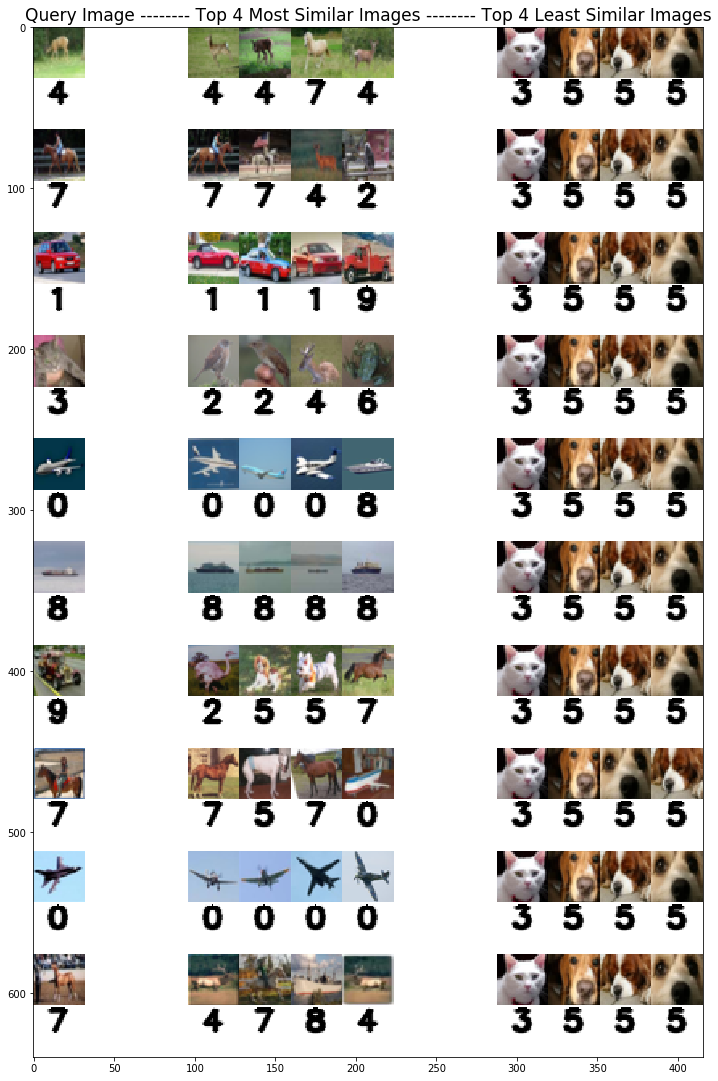

In [21]:
final_stack_image = []
precision_list = []
recall_list = []
model1 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for index in random_indices:
    test_image = X_test[index]
    img_data = image.img_to_array(test_image)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg16_feature = model1.predict(img_data)
    dl_test_flatten = vgg16_feature.flatten()

    #compute similarity
    X_train_dl_df_with_sim = find_sim_vgg16(X_train_dl_df,dl_test_flatten)
    
    #Set the similarity threshold to the top 10 percent (If the images are this similar, retrieve the images)
    sim_threshold = X_train_dl_df_with_sim['SIMILARITY_VGG16'].min() + (X_train_dl_df_with_sim['SIMILARITY_VGG16'].max())/10
    n_retrieved_images = X_train_dl_df_with_sim[X_train_dl_df_with_sim['SIMILARITY_VGG16']<=sim_threshold].shape[0]
    n_relevant_images = 5000 #We know this because each class has 5000 images in the training set

    #Top N most similar images
    top_n_most_sim_indices = list(X_train_dl_df_with_sim.sort_values(['SIMILARITY_VGG16'],ascending=[True])[:n_retrieved_images].index.values)
    top_n_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices]))
    top_4_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices[:4]]))
    top_n_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices]
    top_4_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices[:4]]
    top_4_most_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_most_sim_classes[i]) for i in range(4)]))

    #Top N least similar images
    top_n_least_sim_indices = list(X_train_dl_df_with_sim.sort_values(['SIMILARITY_VGG16'],ascending=[False])[:25].index.values)
    top_n_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices]))
    top_4_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices[:4]]))
    top_n_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices]
    top_4_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices[:4]]
    top_4_least_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_least_sim_classes[i]) for i in range(4)]))
    
    #Calculate precision & recall at the given similarity threshold
    n_similar_images_retrieved = (top_n_most_sim_classes==y_test[index][0]).astype(float).sum()
    precision = (n_similar_images_retrieved/n_retrieved_images).round(4)
    precision_list.append(precision)
    recall = (n_similar_images_retrieved/n_relevant_images).round(4)
    recall_list.append(recall)

    image_stack = np.hstack((test_image,blank,blank,top_4_most_sim_images,blank,blank,top_4_least_sim_images))
    blank_stack = np.hstack((write_on_blank(blank.copy(),y_test[index][0]),blank,blank,top_4_most_sim_blank_classes,
                             blank,blank,top_4_least_sim_blank_classes))
    final_stack_image.append(np.vstack((image_stack,blank_stack)))
    
final_output = np.vstack(tuple([final_stack_image[i] for i in range(num_test_images)]))
print('Mean Precision = ' + str(np.mean(precision_list).round(4)))
print('Mean Recall = ' + str(np.mean(recall_list).round(4)))
plt.figure(figsize=(12,120))
plt.title('Query Image -------- Top 4 Most Similar Images -------- Top 4 Least Similar Images', fontsize = 17)
plt.imshow(final_output)

### VGG19

Mean Precision = 0.244
Mean Recall = 0.2782


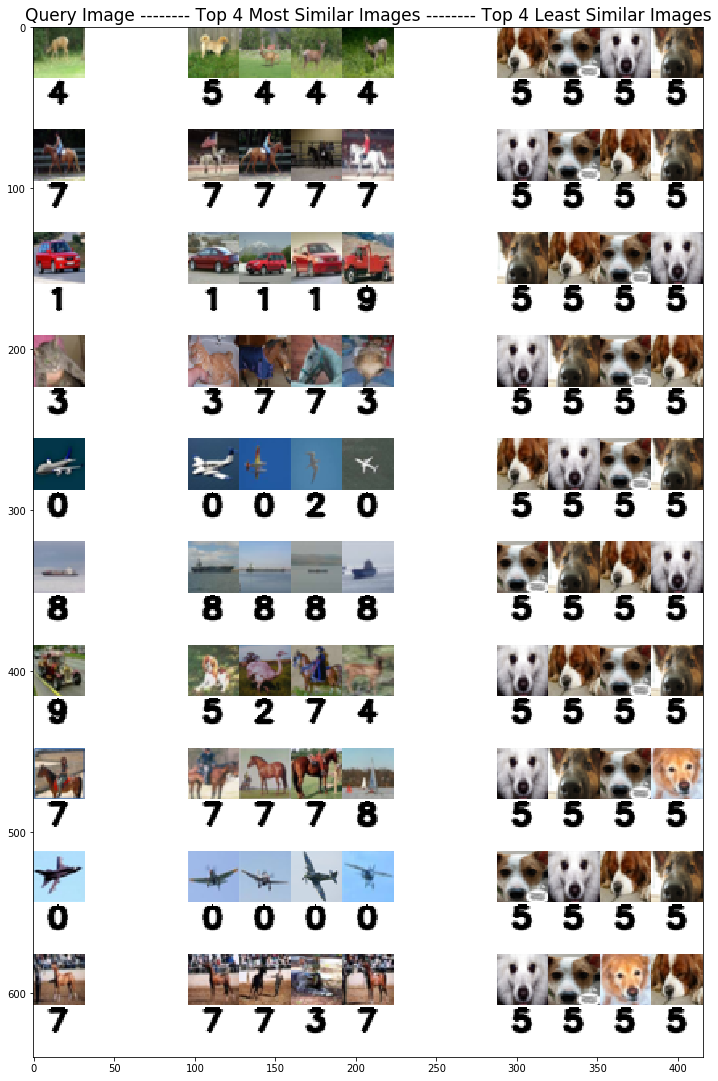

In [22]:
final_stack_image = []
precision_list = []
recall_list = []
model1 = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for index in random_indices:
    test_image = X_test[index]
    img_data = image.img_to_array(test_image)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    vgg19_feature = model1.predict(img_data)
    dl_test_flatten = vgg19_feature.flatten()

    #compute similarity
    X_train_dl_df_with_sim = find_sim_vgg19(X_train_dl_df,dl_test_flatten)
    
    #Set the similarity threshold to the top 10 percent (If the images are this similar, retrieve the images)
    sim_threshold = X_train_dl_df_with_sim['SIMILARITY_VGG19'].min() + (X_train_dl_df_with_sim['SIMILARITY_VGG19'].max())/7
    n_retrieved_images = X_train_dl_df_with_sim[X_train_dl_df_with_sim['SIMILARITY_VGG19']<=sim_threshold].shape[0]
    n_relevant_images = 5000 #We know this because each class has 5000 images in the training set

    #Top N most similar images
    top_n_most_sim_indices = list(X_train_dl_df_with_sim.sort_values(['SIMILARITY_VGG19'],ascending=[True])[:n_retrieved_images].index.values)
    top_n_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices]))
    top_4_most_sim_images = np.hstack(tuple([X_train[i] for i in top_n_most_sim_indices[:4]]))
    top_n_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices]
    top_4_most_sim_classes = [y_train[i][0] for i in top_n_most_sim_indices[:4]]
    top_4_most_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_most_sim_classes[i]) for i in range(4)]))

    #Top N least similar images
    top_n_least_sim_indices = list(X_train_dl_df_with_sim.sort_values(['SIMILARITY_VGG19'],ascending=[False])[:25].index.values)
    top_n_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices]))
    top_4_least_sim_images = np.hstack(tuple([X_train[i] for i in top_n_least_sim_indices[:4]]))
    top_n_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices]
    top_4_least_sim_classes = [y_train[i][0] for i in top_n_least_sim_indices[:4]]
    top_4_least_sim_blank_classes = np.hstack(tuple([write_on_blank(blank.copy(),top_4_least_sim_classes[i]) for i in range(4)]))
    
    #Calculate precision & recall at the given similarity threshold
    n_similar_images_retrieved = (top_n_most_sim_classes==y_test[index][0]).astype(float).sum()
    precision = (n_similar_images_retrieved/n_retrieved_images).round(4)
    precision_list.append(precision)
    recall = (n_similar_images_retrieved/n_relevant_images).round(4)
    recall_list.append(recall)

    image_stack = np.hstack((test_image,blank,blank,top_4_most_sim_images,blank,blank,top_4_least_sim_images))
    blank_stack = np.hstack((write_on_blank(blank.copy(),y_test[index][0]),blank,blank,top_4_most_sim_blank_classes,
                             blank,blank,top_4_least_sim_blank_classes))
    final_stack_image.append(np.vstack((image_stack,blank_stack)))
    
final_output = np.vstack(tuple([final_stack_image[i] for i in range(num_test_images)]))
print('Mean Precision = ' + str(np.mean(precision_list).round(4)))
print('Mean Recall = ' + str(np.mean(recall_list).round(4)))
plt.figure(figsize=(12,120))
plt.title('Query Image -------- Top 4 Most Similar Images -------- Top 4 Least Similar Images', fontsize = 17)
plt.imshow(final_output)

<b>VGG16 produced the best precision. <br>
<b>VGG19 produced the best recall. <br>